# LSTM NN in predicting air pollution. Modeling a forecasting problem to a supervised learning problem.

ref: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
%matplotlib inline
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.tsa.stattools as tsa
import statsmodels.tsa.seasonal as seasonal
import keras
import tensorflow as tf
from datetime import datetime

C:\Users\michaelhsieh\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\michaelhsieh\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Dataset available at https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [3]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('../Data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('../Data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [2]:
dataset=pd.read_csv('../Data/pollution.csv', 
                    index_col=0)

In [3]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001801E3E8940>,
      dtype=object)

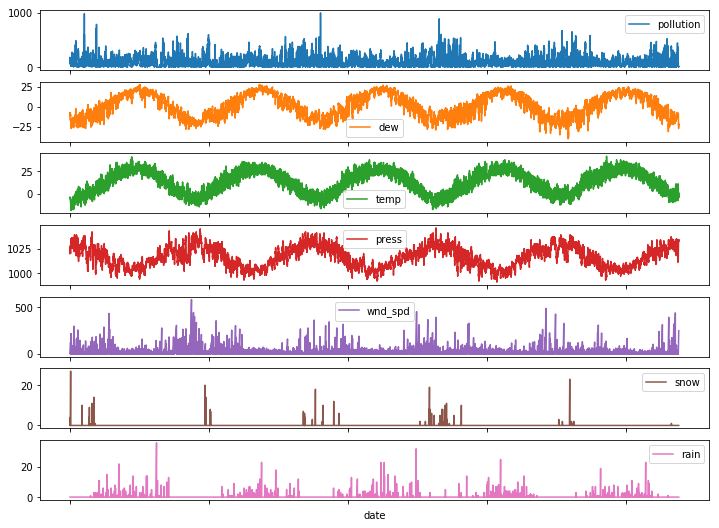

In [4]:
dataset.plot(subplots=True, figsize=(12,10))

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [10]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [11]:
reframed.corr()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
var1(t-1),1.000000,0.157559,-0.090826,-0.045511,0.187448,-0.234327,0.022225,-0.049048,0.955350
var2(t-1),0.157559,1.000000,0.824425,-0.778723,0.232942,-0.296635,-0.034487,0.125051,0.155297
var3(t-1),-0.090826,0.824425,1.000000,-0.827199,0.175610,-0.154811,-0.092730,0.049034,-0.090737
var4(t-1),-0.045511,-0.778723,-0.827199,1.000000,-0.168965,0.185253,0.069036,-0.079837,-0.043935
var5(t-1),0.187448,0.232942,0.175610,-0.168965,1.000000,-0.200006,0.010355,-0.048326,0.207142
var6(t-1),-0.234327,-0.296635,-0.154811,0.185253,-0.200006,1.000000,0.021889,-0.010125,-0.234346
var7(t-1),0.022225,-0.034487,-0.092730,0.069036,0.010355,0.021889,1.000000,-0.009553,0.023343
var8(t-1),-0.049048,0.125051,0.049034,-0.079837,-0.048326,-0.010125,-0.009553,1.000000,-0.054255
var1(t),0.955350,0.155297,-0.090737,-0.043935,0.207142,-0.234346,0.023343,-0.054255,1.000000


In [12]:
reframed.shape

(43799, 9)

In [13]:
dataset.shape

(43800, 8)

In [21]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0558 - val_loss: 0.0665
Epoch 2/50
 - 1s - loss: 0.0404 - val_loss: 0.0727
Epoch 3/50
 - 1s - loss: 0.0269 - val_loss: 0.0656
Epoch 4/50
 - 1s - loss: 0.0205 - val_loss: 0.0552
Epoch 5/50
 - 1s - loss: 0.0178 - val_loss: 0.0493
Epoch 6/50
 - 1s - loss: 0.0165 - val_loss: 0.0366
Epoch 7/50
 - 1s - loss: 0.0156 - val_loss: 0.0281
Epoch 8/50
 - 1s - loss: 0.0151 - val_loss: 0.0216
Epoch 9/50
 - 1s - loss: 0.0150 - val_loss: 0.0196
Epoch 10/50
 - 1s - loss: 0.0149 - val_loss: 0.0177
Epoch 11/50
 - 1s - loss: 0.0147 - val_loss: 0.0165
Epoch 12/50
 - 1s - loss: 0.0148 - val_loss: 0.0160
Epoch 13/50
 - 1s - loss: 0.0147 - val_loss: 0.0155
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0151
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 16/50
 - 1s - loss: 0.0147 - val_loss: 0.0150
Epoch 17/50
 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 18/50
 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 19/50
 - 1s - loss

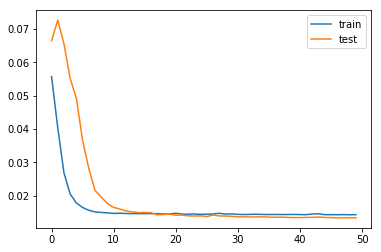

In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], 
                                train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [22]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.488


In [34]:
print(inv_y.shape)
print(inv_yhat.shape)

(35039,)
(35039,)


In [29]:
inv_y

array([31., 20., 19., ..., 10.,  8., 12.], dtype=float32)

In [24]:
inv_yhat

array([34.366245 , 31.036861 , 20.450941 , ...,  7.8039784,  7.775771 ,
        6.0277834], dtype=float32)

In [25]:
test_y

array([[0.03118712],
       [0.02012072],
       [0.01911469],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]], dtype=float32)

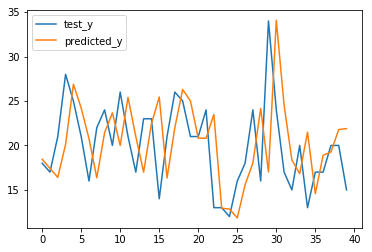

In [33]:
plt.plot(inv_y[400:440], label='test_y')
plt.plot(inv_yhat[400:440], label='predicted_y')
plt.legend()